In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
RANDOM_STATE = 110

train_data = pd.read_csv("C:/Users/KimDongyoung/Desktop/git_LGaimers5/Lg_aimers5/data/train_data.csv")
test_data = pd.read_csv("C:/Users/KimDongyoung/Desktop/git_LGaimers5/Lg_aimers5/data/test_data.csv")

In [3]:
def plot_box(dataframe, column_name):
    """
    주어진 데이터프레임과 열 이름에 대해 박스 플롯을 그리는 함수.

    Parameters:
    dataframe (pd.DataFrame): 데이터프레임
    column_name (str): 열 이름
    """
    plt.figure(figsize=(10, 6))
    plt.boxplot(dataframe[column_name], vert=False)
    plt.xlabel(column_name)
    plt.title(f'Box Plot of {column_name}')
    plt.show()

In [4]:
def value_counts_ratio_count(df, col_name, target_name):
    """
    주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 비율과 갯수, 총 갯수를 출력하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    target_name (str): 타겟 변수 이름
    """
    # 각 값마다 타겟 변수의 비율 계산
    value_counts = df.groupby(col_name)[target_name].value_counts(normalize=True).unstack().fillna(0)
    
    # 각 값마다 타겟 변수의 갯수 계산
    counts = df.groupby(col_name)[target_name].value_counts().unstack().fillna(0)
    
    # 각 값마다 총 갯수 계산
    total_counts = df[col_name].value_counts().rename('Total_Count')
    
    # 비율과 갯수를 합침
    result = value_counts.join(counts, lsuffix='_ratio', rsuffix='_count')
    
    # 총 갯수를 합침
    result = result.join(total_counts, on=col_name)
    
    # 출력 형식 조정
    result.index.name = 'variable'
    print(f"\n{col_name}별 {target_name} 비율 및 갯수\n")
    print(result.rename(columns=lambda x: x.split('_')[0]))

In [5]:
def summarize_grouped_data(df, group_by_columns):
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_columns)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # 'target' 변수의 'AdNormal' 비율과 갯수 계산
        adnormal_count = group['target'].value_counts().get('AbNormal', 0)
        adnormal_ratio = adnormal_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, adnormal_count, adnormal_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', "'AdNormal' count", 'ratio', 'Total'])
    
    # 그룹화된 변수들의 이름을 제목행으로 출력
    print(f"Grouped by: {', '.join(group_by_columns)}")
    print()
    # 데이터프레임 출력
    print(results_df)
    
    return results_df

In [6]:
def plot_abnormal_ratio(dataframe, column_name, target_name, target_value, bins=20):
    """
    주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 특정 값 비율을 계산하고 막대그래프로 표시하는 함수.

    Parameters:
    dataframe (pd.DataFrame): 데이터프레임
    column_name (str): 열 이름
    target_name (str): 타겟 변수 이름
    target_value (str): 타겟 변수의 특정 값
    bins (int): 구간의 수 (기본값은 20)
    """
    def abnormal_ratio(dataframe, column_name, target_name, target_value):
        """
        주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 특정 값 비율을 계산하는 함수.

        Parameters:
        dataframe (pd.DataFrame): 데이터프레임
        column_name (str): 열 이름
        target_name (str): 타겟 변수 이름
        target_value (str): 타겟 변수의 특정 값

        Returns:
        pd.DataFrame: 각 값마다 타겟 변수의 특정 값 비율을 포함하는 데이터프레임
        """
        # 각 값마다 타겟 변수의 특정 값 비율 계산
        value_counts = dataframe.groupby(column_name)[target_name].apply(lambda x: (x == target_value).mean()).reset_index()
        count_counts = dataframe.groupby(column_name)[target_name].count().reset_index()
        
        value_counts.columns = [column_name, 'ratio']
        count_counts.columns = [column_name, 'count']
        
        # 비율과 카운트를 병합
        result = pd.merge(value_counts, count_counts, on=column_name)
        return result

    # column_name 값을 지정된 구간으로 나누기
    dataframe[f'{column_name}_bins'] = pd.cut(dataframe[column_name], bins=bins)

    # 비율 계산
    ratios = abnormal_ratio(dataframe, f'{column_name}_bins', target_name, target_value)

    # 막대그래프 그리기
    plt.figure(figsize=(20, 10))
    barplot = sns.barplot(x=f'{column_name}_bins', y='ratio', data=ratios, color='skyblue')
    plt.xlabel(f'{column_name} (binned)')
    plt.ylabel('AbNormal Ratio')
    plt.title(f'AbNormal Ratio by {column_name} (binned)', pad=30)  # 제목과 그래프 사이의 간격 조정
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

    # 각 막대 위에 비율 값과 카운트 표시
    for p in barplot.patches:
        # 막대의 x 좌표에 해당하는 구간을 찾기
        bin_label = ratios[f'{column_name}_bins'].cat.categories[int(p.get_x() + p.get_width() / 2) - 1]
        count_value = ratios.loc[ratios[f'{column_name}_bins'] == bin_label, 'count'].values[0]
        barplot.annotate(f'{format(p.get_height(), ".2f")} ({count_value})', 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha='center', va='center', 
                         xytext=(0, 9), 
                         textcoords='offset points')

    plt.show()

    # _bins 변수 드랍
    dataframe.drop(columns=[f'{column_name}_bins'], inplace=True)


In [7]:
# train_data와 test_data에서 '?'를 포함하는 열 이름 필터링
train_Process_Desc_col = train_data.filter(like='?').columns
test_Process_Desc_col = test_data.filter(like='?').columns

# 필터링된 열 이름 출력
print("<? column in train_data>")
for col in train_Process_Desc_col:
    print(col)

print("<? column in test_data>")
for col in test_Process_Desc_col:
    print(col)

# ? -> Θ로 변경할 열 이름과 새 열 이름 생성
train_new_columns = {col: col.replace('?', 'Θ') for col in train_Process_Desc_col}
test_new_columns = {col: col.replace('?', 'Θ') for col in test_Process_Desc_col}

# 열 이름 변경
train_data.rename(columns=train_new_columns, inplace=True)
test_data.rename(columns=test_new_columns, inplace=True)

# 'Θ'를 포함하는 열 이름 필터링
train_Process_Desc_col = train_data.filter(like='Θ').columns
test_Process_Desc_col = test_data.filter(like='Θ').columns

# 필터링된 열 이름 출력
print("<Θ in train_data>")
print("train_data:")
for col in train_Process_Desc_col:
    print(col)

print("test_data:")
for col in test_Process_Desc_col:
    print(col)

<? column in train_data>
<? column in test_data>
<Θ in train_data>
train_data:
CURE END POSITION Θ Collect Result_Dam
CURE START POSITION Θ Collect Result_Dam
test_data:
CURE END POSITION Θ Collect Result_Dam
CURE START POSITION Θ Collect Result_Dam


In [26]:
def plot_ratio(df, group_by_column, target_column='target', abnormal_value='AbNormal'):
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_column)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # 'target' 변수의 'AbNormal' 비율과 갯수 계산
        abnormal_count = group[target_column].value_counts().get(abnormal_value, 0)
        abnormal_ratio = abnormal_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, abnormal_count, abnormal_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', f"'{abnormal_value}' count", 'ratio', 'Total'])
    
    # 그래프 크기 설정
    plt.figure(figsize=(15, 5))
    
    # 막대 그래프 생성
    ax = results_df.plot(kind='bar', x='group', y='ratio', legend=False)
    
    # 각 막대 위에 AbNormal 갯수와 총 갯수 표시
    for i, (abnormal_count, total) in enumerate(zip(results_df[f"'{abnormal_value}' count"], results_df['Total'])):
        ax.text(i, results_df['ratio'][i], f'{abnormal_count} ({total})', ha='center', va='bottom', fontsize=8)
    
     # 그래프 제목 및 축 레이블 설정
    ax.set_title(f'{abnormal_value} Ratio by {group_by_column}')
    ax.set_xlabel(group_by_column)
    ax.set_ylabel(f'{abnormal_value} Ratio')
   
    # 그래프 출력
    plt.show()

In [8]:
# '_Dam'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Dam').columns

# 필터링된 열 이름 출력
print("<Dam 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Dam 공정 관련 변수>
CURE END POSITION X Collect Result_Dam
CURE END POSITION Z Collect Result_Dam
CURE END POSITION Θ Collect Result_Dam
CURE SPEED Collect Result_Dam
CURE START POSITION X Collect Result_Dam
CURE START POSITION Θ Collect Result_Dam
DISCHARGED SPEED OF RESIN Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam
DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam
Dispense Volume(Stage1) Collect Result_Dam
Dispense Volume(Stage2) Collect Result_Dam
Dispense Volume(Stage3) Collect Result_Dam
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam
HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam
HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam
HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam
HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam
HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam
HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam
HEAD NORMAL COORDINATE Z AXIS(

In [11]:
train_data_1 = train_data[train_data['Dispenser_num'] == '#1']

In [12]:
train_data_1

,Model.Suffix,Workorder,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,...,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,Receip No Collect Result_Fill2,WorkMode Collect Result_Fill2,target,Dispenser_num
0,AJX75334505,4F1XA938-1,240,2.5,-90,100,1030,-90,16,14.9,...,243.7,243.7,114.612,19.9,7,127,1,NaN,Normal,#1
1,AJX75334505,3KPM0016-2,240,2.5,-90,70,1030,-90,10,21.3,...,243.7,243.7,85.000,19.6,7,185,1,0.0,Normal,#1
4,AJX75334501,3HPM0007-1,240,2.5,-90,70,1030,-90,10,9.7,...,243.7,243.7,85.000,19.7,8,121,1,0.0,Normal,#1
5,AJX75334501,3G1X8297-2,240,2.5,-90,70,1030,-90,10,9.6,...,243.7,243.7,85.000,18.9,8,343,1,0.0,Normal,#1
6,AJX75334501,3M1XH425-1,240,2.5,-90,70,1030,-90,16,13.2,...,243.7,243.7,85.000,19.7,8,483,1,NaN,Normal,#1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40498,AJX75334501,3H1X7981-1,240,2.5,-90,70,1030,-90,10,9.7,...,243.7,243.7,85.000,19.3,8,329,1,0.0,Normal,#1
40499,AJX75334501,4E1X9169-1,240,2.5,-90,85,1030,-90,16,14.7,...,243.7,243.7,114.612,19.5,8,116,1,NaN,Normal,#1
40501,AJX75334501,3J1XF434-2,240,2.5,-90,70,1030,-90,10,17.0,...,243.7,243.7,85.000,19.2,1,318,1,0.0,Normal,#1
40503,AJX75334501,4C1XD438-1,240,2.5,-90,100,1030,-90,16,14.2,...,243.7,243.7,85.000,19.7,1,27,1,NaN,Normal,#1


In [13]:
value_counts_ratio_count(train_data_1, 'Model.Suffix', 'target')


Model.Suffix별 target 비율 및 갯수

             AbNormal    Normal  AbNormal   Normal  Total
variable                                                 
AJX75334501  0.058545  0.941455    1260.0  20262.0  21522
AJX75334502  0.070205  0.929795     127.0   1682.0   1809
AJX75334503  0.000000  1.000000       0.0      2.0      2
AJX75334505  0.045097  0.954903      63.0   1334.0   1397
AJX75334506  0.032258  0.967742       2.0     60.0     62
AJX75334507  0.067708  0.932292      13.0    179.0    192
AJX75334508  0.037037  0.962963       1.0     26.0     27


In [14]:
# Identify columns with only one unique value
columns_with_one_unique_value = [col for col in train_data_1.columns if train_data_1[col].nunique() == 1]

# Remove these columns from the dataset
train_data_1_cleaned = train_data_1.drop(columns=columns_with_one_unique_value)

In [15]:
columns_with_one_unique_value

['CURE END POSITION X Collect Result_Dam',
 'CURE END POSITION Z Collect Result_Dam',
 'CURE END POSITION Θ Collect Result_Dam',
 'CURE START POSITION X Collect Result_Dam',
 'CURE START POSITION Θ Collect Result_Dam',
 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam',
 'WorkMode Collect Result_Dam',
 'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
 'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1',
 'WorkMode Collect Result_Fill1',
 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2',
 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',
 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect 

In [21]:
train_data_1_cleaned.columns.to_list()

['Model.Suffix',
 'Workorder',
 'CURE SPEED Collect Result_Dam',
 'DISCHARGED SPEED OF RESIN Collect Result_Dam',
 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
 'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam',
 'Dispense Volume(Stage1) Collect Result_Dam',
 'Dispense Volume(Stage2) Collect Result_Dam',
 'Dispense Volume(Stage3) Collect Result_Dam',
 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',
 'Head Clean Position Z Coll

Cure speed

In [17]:
value_counts_ratio_count(train_data_1_cleaned, 'CURE SPEED Collect Result_Dam', 'target')


CURE SPEED Collect Result_Dam별 target 비율 및 갯수

          AbNormal    Normal  AbNormal  Normal  Total
variable                                             
70        0.060943  0.939057      1328   20463  21791
85        0.042642  0.957358        51    1145   1196
95        0.012048  0.987952         1      82     83
100       0.049430  0.950570        52    1000   1052
105       0.038245  0.961755        34     855    889


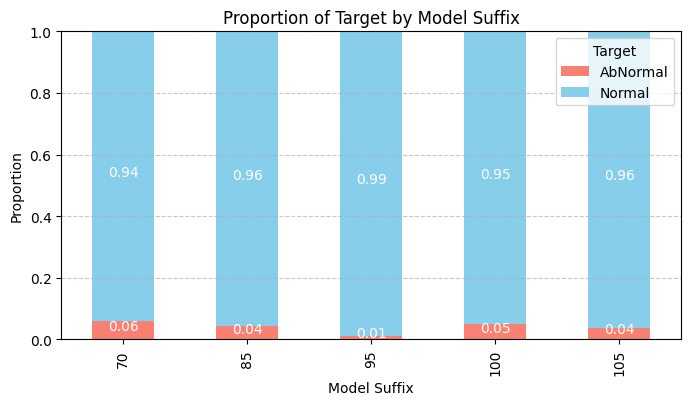

In [18]:
### CURE SPEED Collect Result_Dam에 따른 타깃값

# model suffix와 target 값에 따른 비율 계산
count_df = train_data_1_cleaned.groupby(['CURE SPEED Collect Result_Dam', 'target']).size().unstack(fill_value=0)

# 각 model suffix에 대해 target 비율 계산
count_df = count_df.div(count_df.sum(axis=1), axis=0)

# 비율 시각화
count_df.plot(kind='bar', stacked=True, color=['salmon', 'skyblue'], figsize=(8, 4))

plt.xlabel('Model Suffix')
plt.ylabel('Proportion')
plt.title('Proportion of Target by Model Suffix')
plt.legend(title='Target', loc='upper right')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 그래프 위에 비율 표시
for i in range(count_df.shape[0]):
    for j in range(count_df.shape[1]):
        plt.text(i, count_df.iloc[i, j] / 2 + count_df.iloc[i, :j].sum(), f"{count_df.iloc[i, j]:.2f}", ha='center', color='white')

plt.show()

<Figure size 1000x500 with 0 Axes>

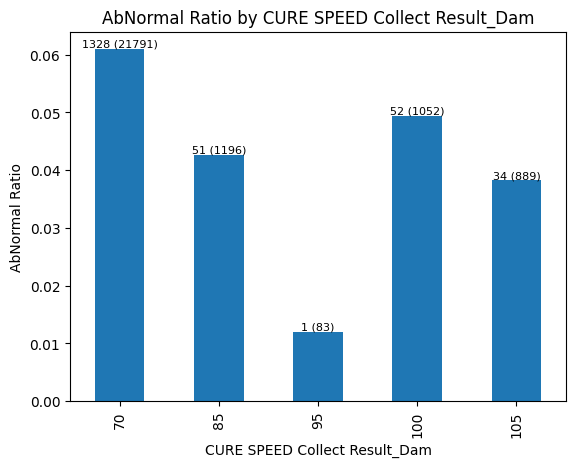

In [20]:
plot_ratio(train_data_1_cleaned, 'CURE SPEED Collect Result_Dam')

Resin 속도와 도포시간 간의 관계

<Figure size 1000x500 with 0 Axes>

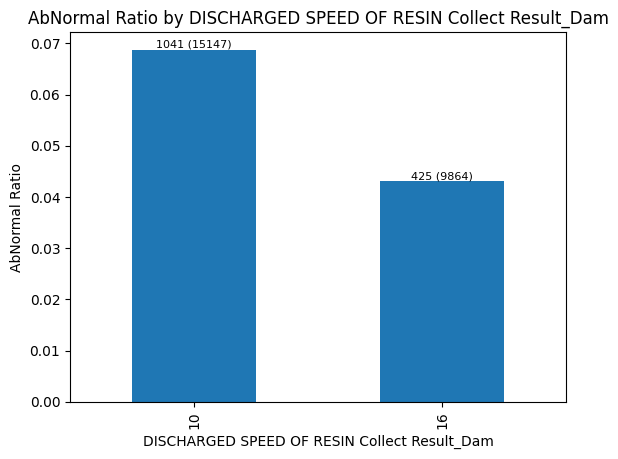

In [22]:
plot_ratio(train_data_1_cleaned, 'DISCHARGED SPEED OF RESIN Collect Result_Dam')


<Figure size 1500x500 with 0 Axes>

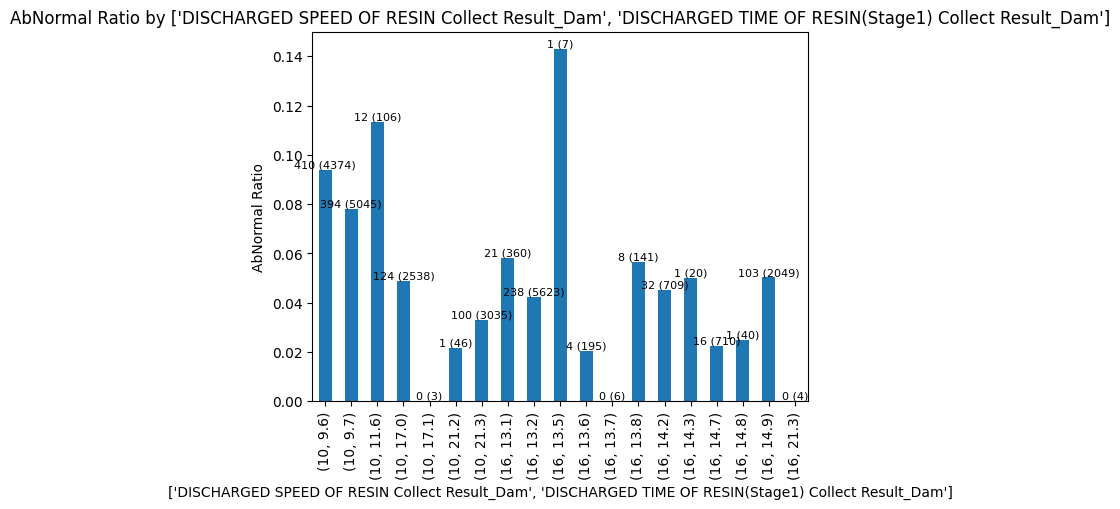

In [29]:
plot_ratio(train_data_1_cleaned, [
    'DISCHARGED SPEED OF RESIN Collect Result_Dam'
    , 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam'
    ])

<Figure size 1000x500 with 0 Axes>

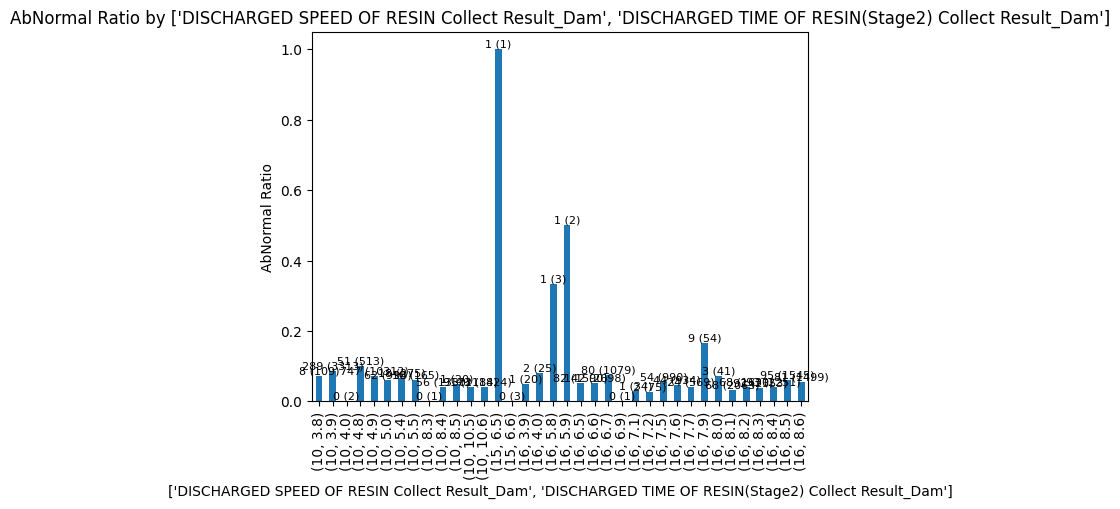

In [24]:
plot_ratio(train_data, [
    'DISCHARGED SPEED OF RESIN Collect Result_Dam'
    , 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam'
    ])

<Figure size 1500x500 with 0 Axes>

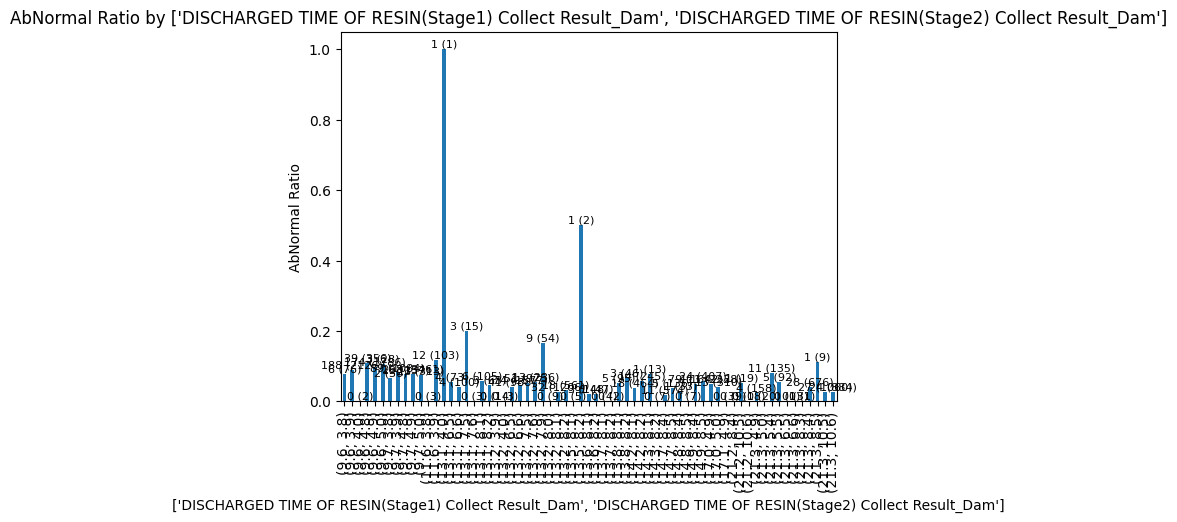

In [30]:
plot_ratio(train_data_1_cleaned, [
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam'
    , 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam'
    ])

<Figure size 1500x500 with 0 Axes>

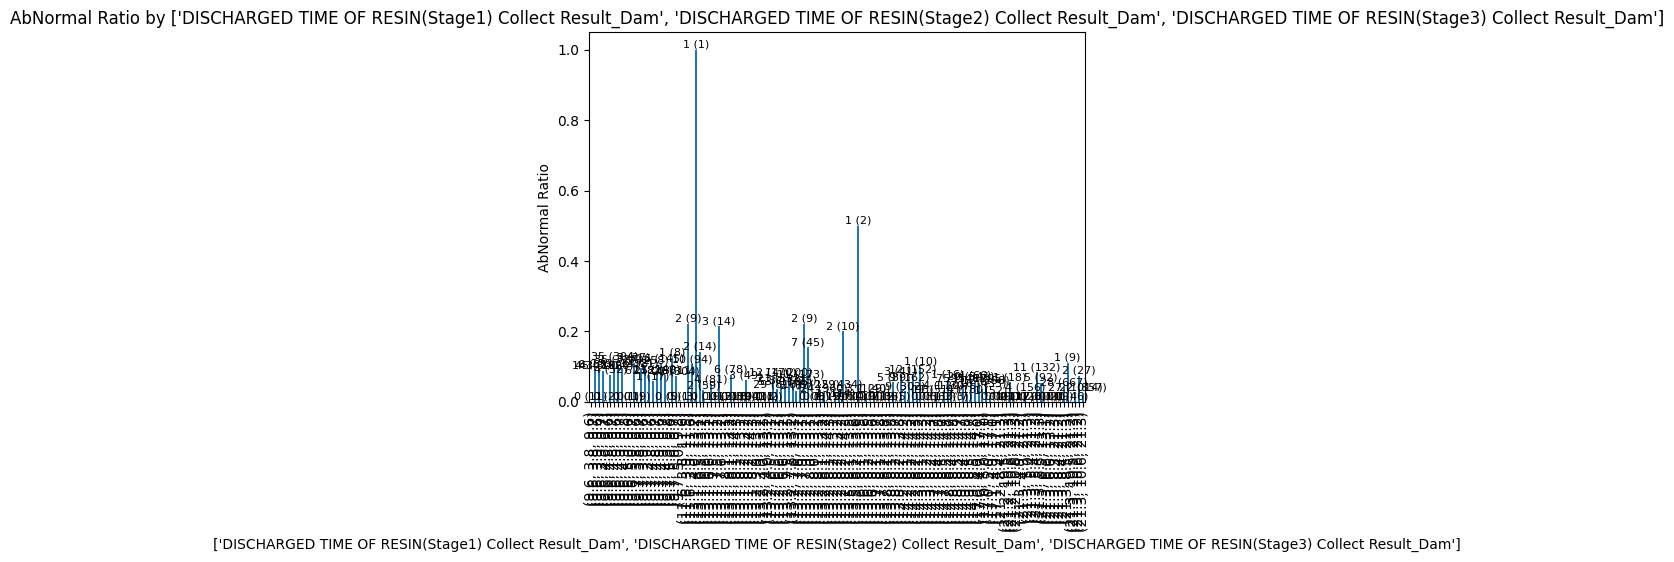

In [31]:
plot_ratio(train_data_1_cleaned, [
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam'
    , 'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam'
    ])

<Figure size 1500x500 with 0 Axes>

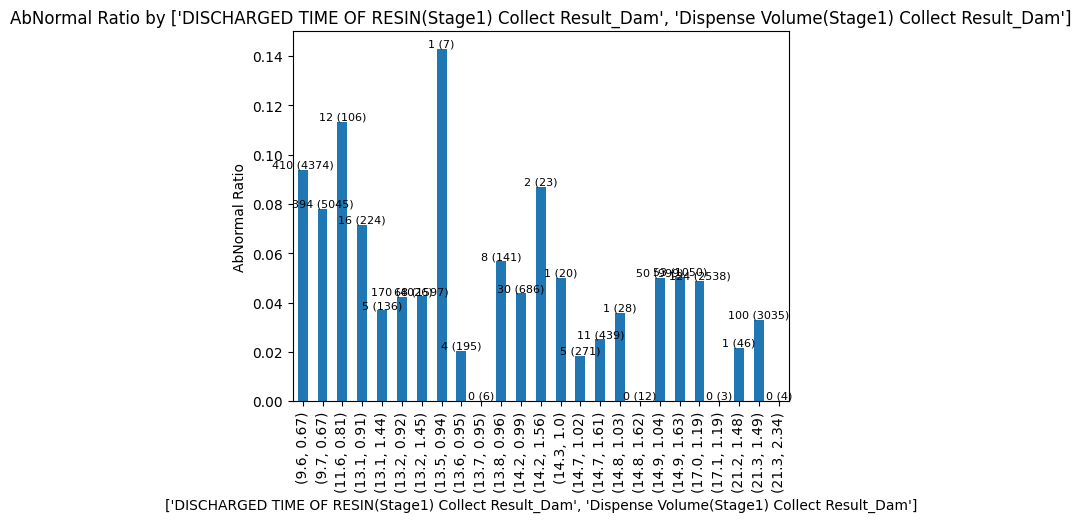

In [32]:
plot_ratio(train_data_1_cleaned, [
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam'
    , 'Dispense Volume(Stage1) Collect Result_Dam'
    ])

<Figure size 1500x500 with 0 Axes>

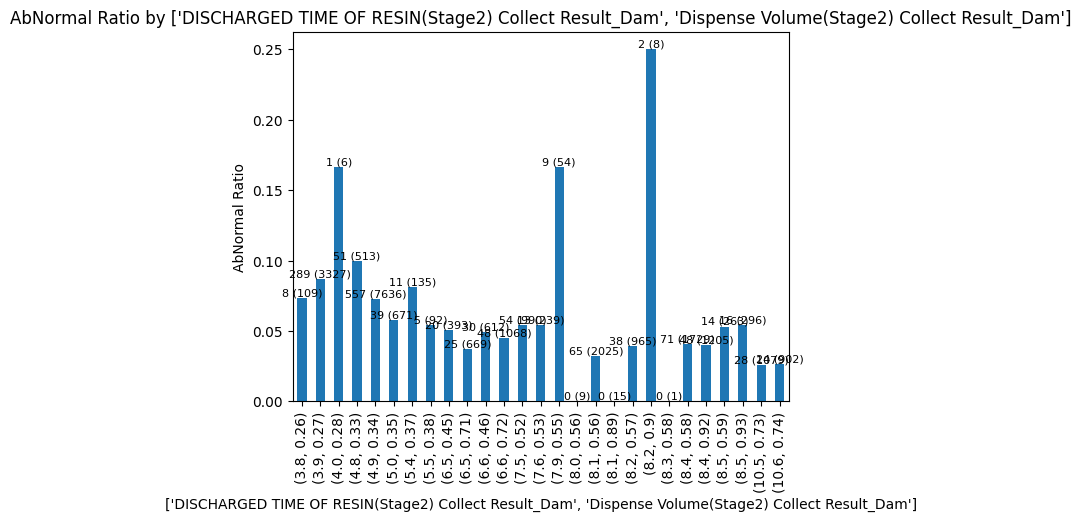

In [33]:
plot_ratio(train_data_1_cleaned, [
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam'
    , 'Dispense Volume(Stage2) Collect Result_Dam'
    ])

<Figure size 1500x500 with 0 Axes>

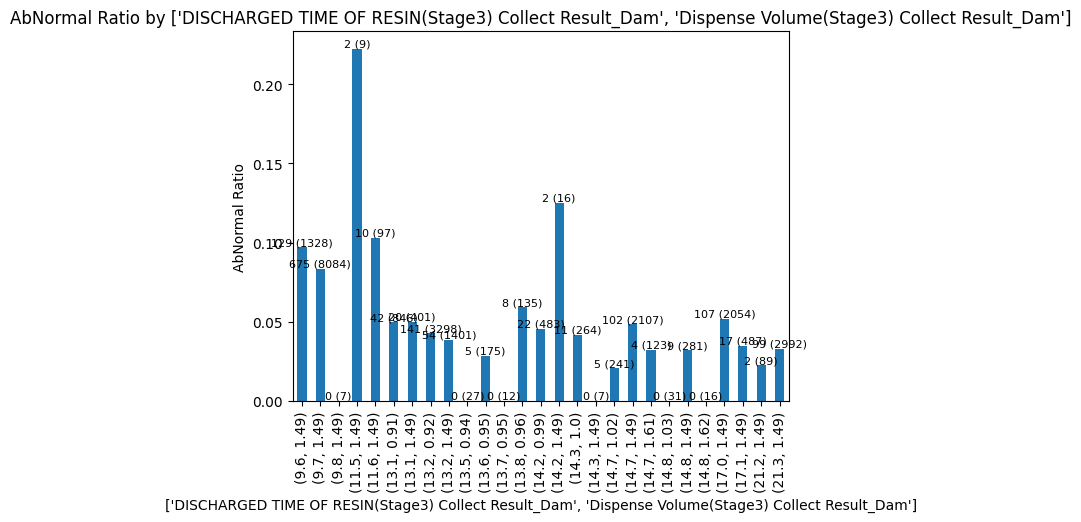

In [34]:
plot_ratio(train_data_1_cleaned, [
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam'
    , 'Dispense Volume(Stage3) Collect Result_Dam'
    ])